# Plotting SWOT data from NATL60

**purpose**
 - testing plotting of SWOT pseudo-data
 - testing computation of laplacian via convolution with derivatives of Gaussian 

**what's next**
 - plots with cartopy

## Modules

In [2]:
import glob
import netCDF4
from netCDF4 import Dataset as ncopen
import numpy as npy
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import GriddedData
%matplotlib inline

import matplotlib.cm as mplcm
import colormaps as cmaps
import matplotlib.cm as cm
cm.register_cmap(name='viridis', cmap=cmaps.viridis)
#import seaborn as sns
seq_cmap = cmaps.viridis # future default matplotlib
div_cmap = mplcm.seismic

## Data and parameters

In [3]:
#- user parameters
#_datadir = '/home/users/bouttier/NATL60_SWOT/output_2007_2008/'
#_datadir = '/Users/lesommer/work/2015/swot-NATL60/'
_datadir = '/Users/lesommer/data/NATL60/SWOT/LAB/'
#_datadir = '/Users/lesommer/data/NATL60/SWOT/full/'
_namcoord = 'coord_grid_NEMO'
_namfiles = 'swot_nemo'
_namdescr = 'swot_simulator.output'

#- physical parameters
grav = 9.81
rho0 = 1020.

#- plot parameters
sqsize=15

## Core tools

In [10]:
class container(object):
    "Empty container"
    def __init__(self,**kwargs):
        for key in kwargs:
            exec('self.' + key + " = kwargs['" + key + "']")

def masked(array):
    m1 = npy.ma.masked_invalid(array)
    m2 = npy.ma.masked_equal(m1,0.)
    return m2

def read_coordfile(filename):
    #print filename
    ncfile = ncopen(filename,'r')
    lon = ncfile.variables['lon'][:]
    lat = ncfile.variables['lat'][:]
    ncfile.close()
    return lon,lat

def read_swotfile(filename):
    #print filename
    ncfile = ncopen(filename,'r')
    SSH_obs = masked(ncfile.variables['SSH_obs'][:])
    SSH_model = masked(ncfile.variables['SSH_model'][:])
    ncfile.close()
    return SSH_obs, SSH_model

def read_time(filename):
    ncfile = ncopen(filename,'r')
    time = ncfile.variables['time'][:]
    ncfile.close()
    return time.mean()



## Data descriptor class


In [11]:
## should soon move to a module
class swot_data:
    "Handler for simulated SWOT data"
    def __init__(self,datadir=None,namcoord=None,namfiles=None,namdescr=None):
        self.datadir = datadir
        self.namcoord = namcoord
        self.namfiles = namfiles
        self.namdescr = namdescr
        self.coord = {}
        self.data = {}
        self.cycles = self.get_list_of_cycles()
        self.passes = self.get_list_of_passes()
        self.timing = None
        self.grids = {}
        self.corio = {}
        for npass in self.passes:
            self.coord[npass] = None
            self.data[npass] = {}
            for ncycl in self.cycles:
                self.data[npass][ncycl] = None

    #
    #- Loading
    #
    def load_descr(self):
        self.simulator_params = container()
        fdescr = open(self.datadir + self.namdescr)
        flines = fdescr.readlines()
        fdescr.close()
        for line in flines:
            try:
                exec('self.simulator_params.' + line)
            except:
                pass
        return 

    def test_npass(self,npass):
        if npass not in self.passes:
            print 'npass not in list of passes'

    def test_ncycl(self,ncycl):
        if ncycl not in self.cycles:
            print 'ncycl not in list of cycles'

    def get_list_of_coordfiles(self):
        return glob.glob(_datadir + self.namcoord + '*.nc')

    def get_list_of_swotfiles(self):
        return glob.glob(_datadir + self.namfiles + '*.nc')

    def get_list_of_cycles(self):
        swotfiles = self.get_list_of_swotfiles()
        swotcycles = [s.split('_c')[-1].split('_')[0] for s in swotfiles]
        npcycles = npy.array(swotcycles,dtype=int)
        from collections import Counter
        dictcount = Counter(npcycles)
        return dictcount.keys()

    def get_list_of_passes(self):
        swotfiles = self.get_list_of_swotfiles()
        swotpasses = [s.split('_p')[-1].split('.')[0] for s in swotfiles]
        nppasses = npy.array(swotpasses,dtype=int)
        from collections import Counter
        dictcount = Counter(nppasses)
        passes = dictcount.keys()
        passes.sort()
        return passes

    def load_timing(self):
        if self.timing is None:
            swotfiles = self.get_list_of_swotfiles()
            times = [read_time(swotfile) for swotfile in swotfiles]
            passes = [s.split('_p')[-1].split('.')[0] for s in swotfiles]
            cycles = [s.split('_c')[-1].split('_')[0] for s in swotfiles]
            o = npy.array([times,cycles,passes],dtype=float).transpose()
            self.timing = o

    def get_passes(self,t0=None,dt=None):
        "Return the list of cycle and passes in a time window."
        self.load_timing()
        t = self.timing[:,0]
        indices = npy.where( (t>(t0-dt/2.)) * (t<(t0+dt/2.)) )[0]
        list_passes = []
        for index in indices:
            ncycl = int(self.timing[index][1])
            npass = int(self.timing[index][2])
            list_passes.append({'ncycl':ncycl,'npass':npass})
        return list_passes

    def load_swotfile(self,npass=None,ncycl=None):
        filename = self.datadir + self.namfiles \
                + '_c' + str(ncycl).zfill(2) \
                + '_p' + str(npass).zfill(3) + '.nc'
        self.data[npass][ncycl] =  read_swotfile(filename)

    def get_swotdata(self,npass=None,ncycl=None):
        self.test_npass(npass)
        self.test_ncycl(ncycl)
        if self.data[npass][ncycl] is None:
            self.load_swotfile(npass=npass,ncycl=ncycl)
        return self.data[npass][ncycl]

    def load_coordfile(self,npass=None):
        filename = self.datadir + self.namcoord \
                                + '_' + str(npass).zfill(3) + '.nc'
        self.coord[npass] = read_coordfile(filename)

    def get_coord(self,npass=None):
        self.test_npass(npass)
        if self.coord[npass] is None:
            self.load_coordfile(npass=npass)
        return self.coord[npass]
    #
    #- Operations
    #
    def get_grid(self,npass=None):
        lon,lat = self.get_coord(npass=npass)
        self.grids[npass] = GriddedData.grid2D(navlat=lat,navlon=lon)

    def get_corio(self,npass=None):
        if not(self.corio.has_key(npass)):
            self.corio[npass] = GriddedData.corio(self.grids[npass])

    def compute_laplacian(self,ssh,npass=None,blur=None):
        self.get_grid(npass)
        self.get_corio(npass=npass)
        grd = self.grids[npass]
        lap = grd.div(grd.grad(ssh))
        lap = npy.ma.masked_greater(masked(lap),10)
        ratio = grav * lap / self.corio[npass] * rho0
        return ratio
    
    def compute_laplacian_of_gaussian(self,ssh,npass=None,sigma=1.):
        import SimpleITK as sitk
        import numpy as np
        image = sitk.GetImageFromArray(np.nan_to_num(ssh),isVector=False)
        #image = sitk.VectorMagnitude(colorimage)
        #lap =
        rgsmootherfilter = sitk.LaplacianRecursiveGaussianImageFilter()
        rgsmootherfilter.SetSigma(sigma)
        rgsmootherfilter.SetNormalizeAcrossScale(True)
        lap_image  = rgsmootherfilter.Execute(image)
        lap = sitk.GetArrayFromImage(lap_image)
        #plt.imshow(lap,cmap=cm.gray);
        #print(lap.max())
        #import pdb; pdb.set_trace()
        # should deal with grid (meter)...
        self.get_grid(npass)
        self.get_corio(npass=npass)
        ratio = grav * lap / self.corio[npass] * rho0
        return ratio
    
    #
    #- Plotting
    #
    def plot_pass(self,error=True,blur=None,\
        npass=None,ncycl=None,vmin=None,vmax=None,\
                    colorbar=True,show=True,cmap=None):
        lon,lat = self.get_coord(npass=npass)
        SSH_obs, SSH_model = self.get_swotdata(npass=npass,ncycl=ncycl)
        if error:
            ssh = SSH_obs
        else:
            ssh = SSH_model
        if blur:
            ssh = GriddedData.blur_image(ssh,blur,blur)
        cs = plt.pcolormesh(lon,lat,ssh,vmin=vmin,vmax=vmax,hold=not(show),cmap=cmap)
        plt.grid('on')
        plt.tight_layout() # useful ? 
        if colorbar:plt.colorbar()
        if show:plt.show()

    def plot_laplacian(self,error=True,blur=None,\
                        npass=None,ncycl=None,vmin=None,vmax=None,\
                        colorbar=True,show=True,cmap=None):
        lon,lat = self.get_coord(npass=npass)
        SSH_obs, SSH_model = self.get_swotdata(npass=npass,ncycl=ncycl)
        if error:
            ssh = SSH_obs
        else:
            ssh = SSH_model
        if blur:
            ssh = GriddedData.blur_image(ssh,blur,blur)
        lap = self.compute_laplacian(ssh,npass=npass) 
        plt.pcolormesh(lon,lat,lap,vmin=vmin,vmax=vmax,hold=not(show),cmap=cmap)
        plt.grid('on')
        if colorbar:plt.colorbar()
        if show:plt.show()

    def plot_laplacian_of_gaussian(self,error=True,sigma=None,\
                        npass=None,ncycl=None,vmin=None,vmax=None,\
                        colorbar=True,show=True,cmap=None):
        lon,lat = self.get_coord(npass=npass)
        SSH_obs, SSH_model = self.get_swotdata(npass=npass,ncycl=ncycl)
        if error:
            ssh = SSH_obs
        else:
            ssh = SSH_model
        lap = self.compute_laplacian_of_gaussian(ssh,npass=npass,sigma=sigma)
        plt.pcolormesh(lon,lat,lap,vmin=vmin,vmax=vmax,hold=not(show),cmap=cmap)
        plt.grid('on')
        if colorbar:plt.colorbar()
        if show:plt.show()
            
    def plot_passes(self,t0=None,dt=None,**kwargs):
        listpasses = self.get_passes(t0=t0,dt=dt)
        for p in listpasses:
            npass,ncycl = p['npass'],p['ncycl']
            self.plot_pass(npass=npass,ncycl=ncycl,\
                    colorbar=False,show=False,**kwargs)
        plt.colorbar()


## Testing plots of pseudo-data

In [5]:
swotdata = swot_data(datadir=_datadir,namcoord=_namcoord,namfiles=_namfiles,namdescr=_namdescr)

/Users/lesommer/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


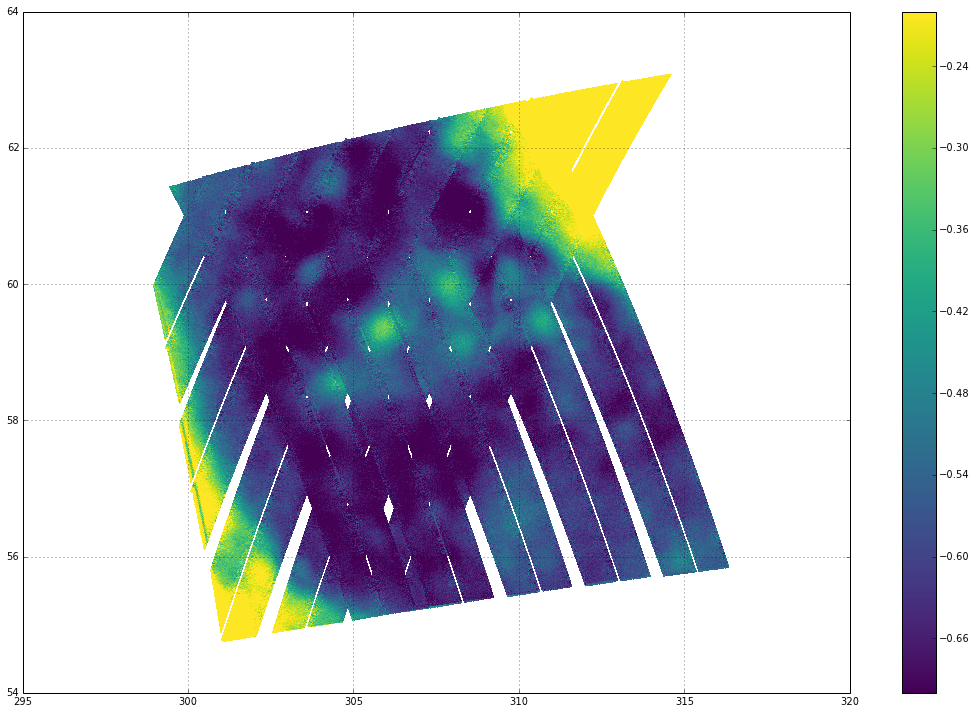

In [11]:
fig = plt.figure(figsize=(15,10), dpi=80, facecolor='w', edgecolor='k') # settings of the graphic
swotdata.plot_passes(t0=8+21*5,dt=5,error=True,vmin=-0.7,vmax=-0.2,cmap=seq_cmap)

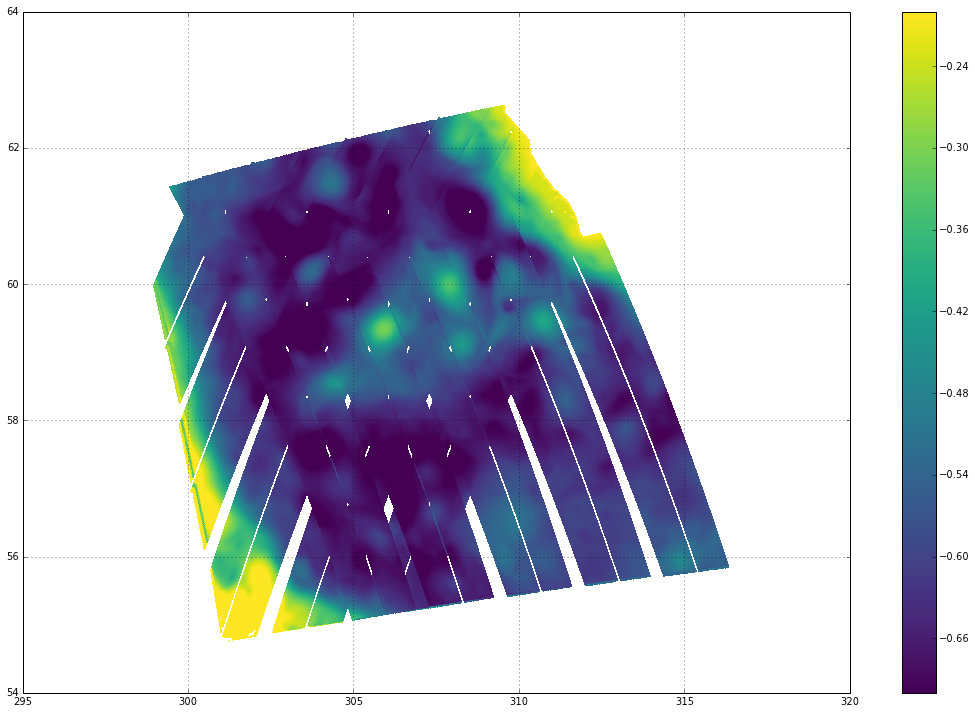

In [34]:
fig = plt.figure(figsize=(15,10), dpi=80, facecolor='w', edgecolor='k') # settings of the graphic
swotdata.plot_passes(t0=8+21*5,dt=5,error=False,vmin=-0.7,vmax=-0.2,cmap=seq_cmap)

In [7]:
lp = swotdata.get_list_of_passes()
len(lp)

42

In [8]:
lc = swotdata.get_list_of_cycles()
len(lc)

22

## Testing computation of Laplacian

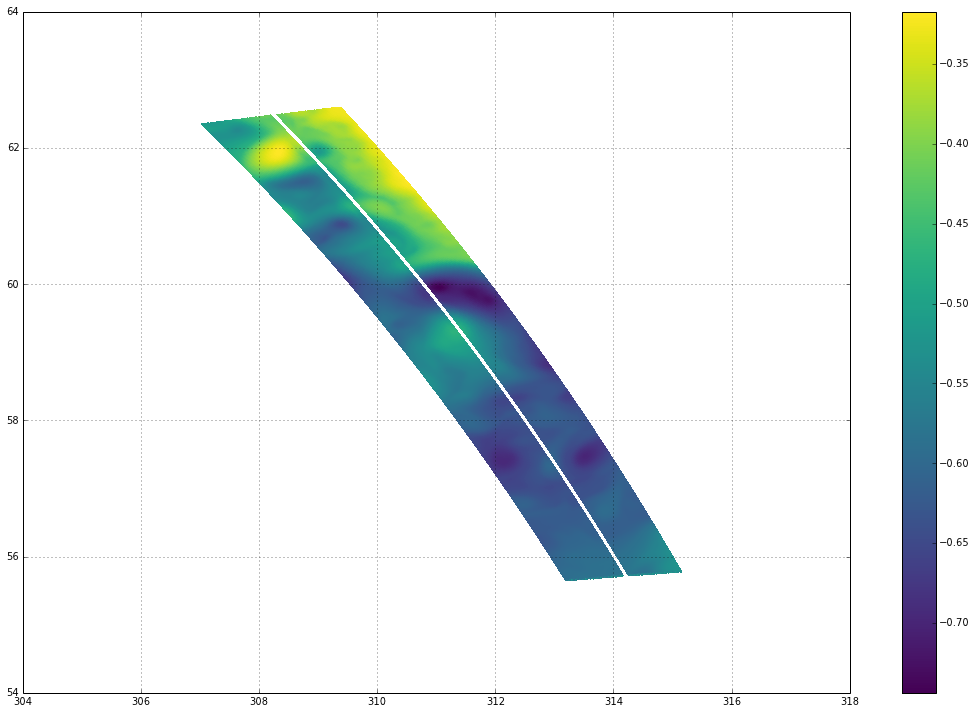

In [20]:
fig = plt.figure(figsize=(15,10), dpi=80, facecolor='w', edgecolor='k') # settings of the graphic
swotdata.plot_pass(npass=lp[35],ncycl=lc[5],error=False,cmap=seq_cmap)

/Users/lesommer/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


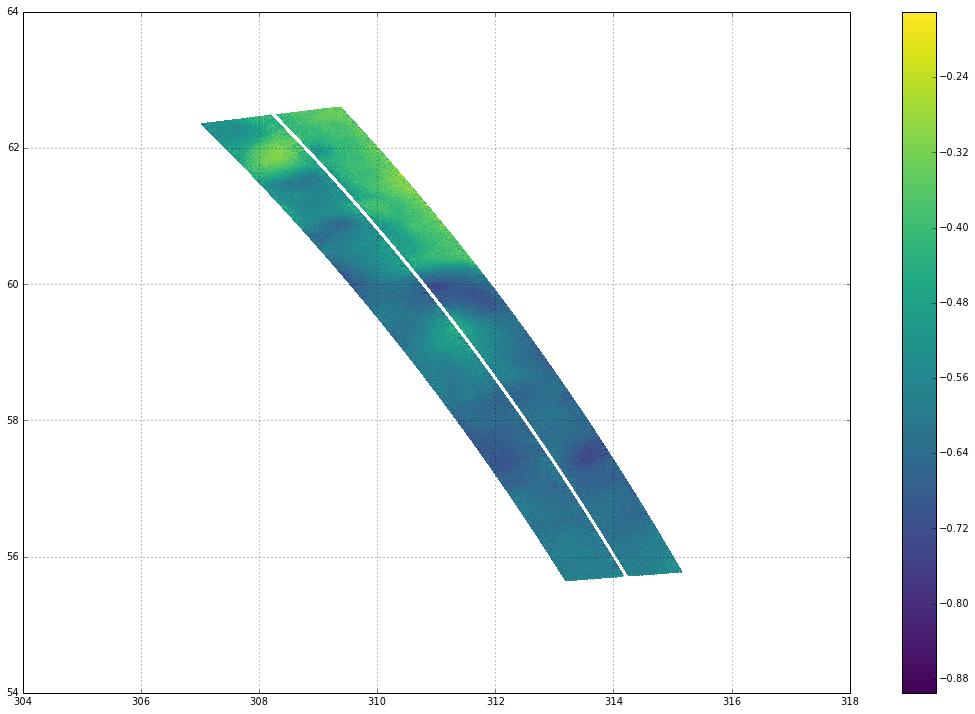

In [12]:
fig = plt.figure(figsize=(15,10), dpi=80, facecolor='w', edgecolor='k') # settings of the graphic
swotdata.plot_pass(npass=lp[35],ncycl=lc[5],error=True,cmap=seq_cmap)

/Users/lesommer/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy-1.11.0rc1-py2.7-macosx-10.6-x86_64.egg/numpy/ma/core.py:812: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/Users/lesommer/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy-1.11.0rc1-py2.7-macosx-10.6-x86_64.egg/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


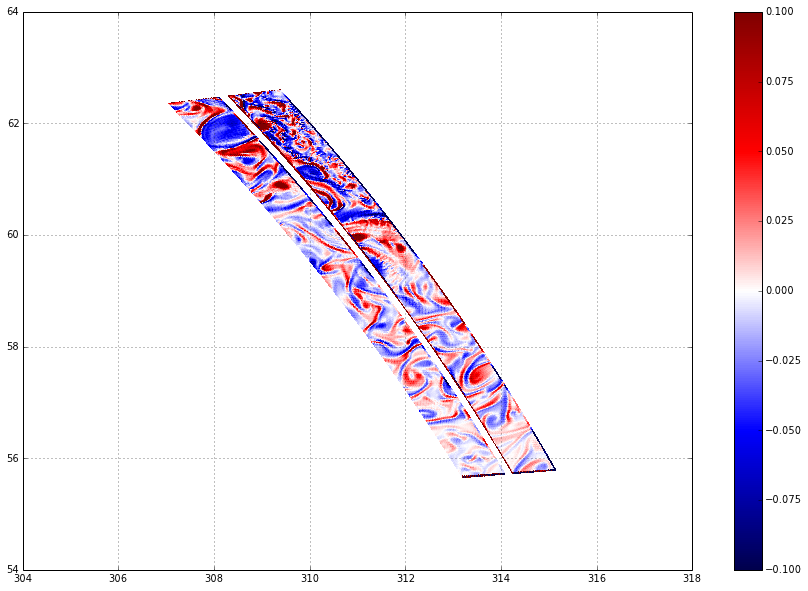

In [21]:
fig = plt.figure(figsize=(15,10), dpi=80, facecolor='w', edgecolor='k') # settings of the graphic
swotdata.plot_laplacian(npass=lp[35],ncycl=lc[5],vmin=-1e-1,vmax=1e-1,error=False,cmap=div_cmap)

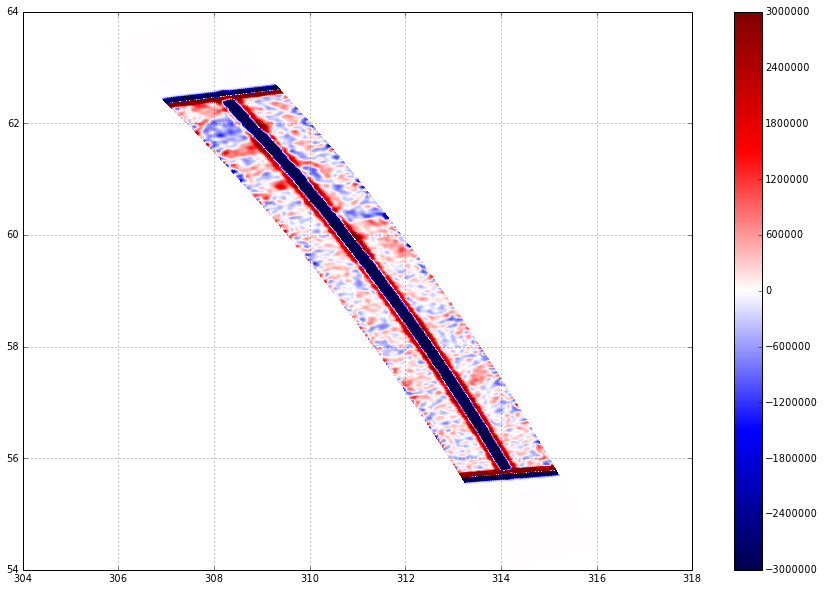

In [25]:
fig = plt.figure(figsize=(15,10), dpi=80, facecolor='w', edgecolor='k') # settings of the graphic
swotdata.plot_laplacian_of_gaussian(npass=lp[35],ncycl=lc[5],vmin=-0.3e7,vmax=0.3e7,error=True,sigma=3.7,cmap=div_cmap)